In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pickle
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer

# Data loading & Understanding

In [2]:
df = pd.read_csv("ipl_matches.csv")

In [3]:
df

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,IPL-2017,Rajkot,07-04-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,IPL-2017,Indore,08-04-2017,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,11347,IPL-2019,Mumbai,05-05-2019,Kolkata Knight Riders,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,9,HH Pandya,Wankhede Stadium,Nanda Kishore,O Nandan,S Ravi
752,11412,IPL-2019,Chennai,07-05-2019,Chennai Super Kings,Mumbai Indians,Chennai Super Kings,bat,normal,0,Mumbai Indians,0,6,AS Yadav,M. A. Chidambaram Stadium,Nigel Llong,Nitin Menon,Ian Gould
753,11413,IPL-2019,Visakhapatnam,08-05-2019,Sunrisers Hyderabad,Delhi Capitals,Delhi Capitals,field,normal,0,Delhi Capitals,0,2,RR Pant,ACA-VDCA Stadium,NaN,NaN,NaN
754,11414,IPL-2019,Visakhapatnam,10-05-2019,Delhi Capitals,Chennai Super Kings,Chennai Super Kings,field,normal,0,Chennai Super Kings,0,6,F du Plessis,ACA-VDCA Stadium,Sundaram Ravi,Bruce Oxenford,Chettithody Shamshuddin


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               756 non-null    int64 
 1   Season           756 non-null    object
 2   city             749 non-null    object
 3   date             756 non-null    object
 4   team1            756 non-null    object
 5   team2            756 non-null    object
 6   toss_winner      756 non-null    object
 7   toss_decision    756 non-null    object
 8   result           756 non-null    object
 9   dl_applied       756 non-null    int64 
 10  winner           752 non-null    object
 11  win_by_runs      756 non-null    int64 
 12  win_by_wickets   756 non-null    int64 
 13  player_of_match  752 non-null    object
 14  venue            756 non-null    object
 15  umpire1          754 non-null    object
 16  umpire2          754 non-null    object
 17  umpire3          119 non-null    ob

In [5]:
df.describe()

,id,dl_applied,win_by_runs,win_by_wickets
count,756.000000,756.000000,756.000000,756.000000
mean,1792.178571,0.025132,13.283069,3.350529
std,3464.478148,0.156630,23.471144,3.387963
min,1.000000,0.000000,0.000000,0.000000
25%,189.750000,0.000000,0.000000,0.000000
50%,378.500000,0.000000,0.000000,4.000000
75%,567.250000,0.000000,19.000000,6.000000
max,11415.000000,1.000000,146.000000,10.000000


# Data Cleaning

In [6]:
df.isnull().sum()

id                   0
Season               0
city                 7
date                 0
team1                0
team2                0
toss_winner          0
toss_decision        0
result               0
dl_applied           0
winner               4
win_by_runs          0
win_by_wickets       0
player_of_match      4
venue                0
umpire1              2
umpire2              2
umpire3            637
dtype: int64

In [7]:
category_cols = ['city', 'winner', 'player_of_match', 'umpire1', 'umpire2']
imputer = SimpleImputer(strategy = 'most_frequent')
df[category_cols] = imputer.fit_transform(df[category_cols])

In [8]:
df.isnull().sum()

id                   0
Season               0
city                 0
date                 0
team1                0
team2                0
toss_winner          0
toss_decision        0
result               0
dl_applied           0
winner               0
win_by_runs          0
win_by_wickets       0
player_of_match      0
venue                0
umpire1              0
umpire2              0
umpire3            637
dtype: int64

In [9]:
df = df.drop(columns = ['umpire3', 'id', 'date', 'Season'], axis = 1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   city             756 non-null    object
 1   team1            756 non-null    object
 2   team2            756 non-null    object
 3   toss_winner      756 non-null    object
 4   toss_decision    756 non-null    object
 5   result           756 non-null    object
 6   dl_applied       756 non-null    int64 
 7   winner           756 non-null    object
 8   win_by_runs      756 non-null    int64 
 9   win_by_wickets   756 non-null    int64 
 10  player_of_match  756 non-null    object
 11  venue            756 non-null    object
 12  umpire1          756 non-null    object
 13  umpire2          756 non-null    object
dtypes: int64(3), object(11)
memory usage: 82.8+ KB


In [11]:
df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   city             756 non-null    object
 1   team1            756 non-null    object
 2   team2            756 non-null    object
 3   toss_winner      756 non-null    object
 4   toss_decision    756 non-null    object
 5   result           756 non-null    object
 6   dl_applied       756 non-null    int64 
 7   winner           756 non-null    object
 8   win_by_runs      756 non-null    int64 
 9   win_by_wickets   756 non-null    int64 
 10  player_of_match  756 non-null    object
 11  venue            756 non-null    object
 12  umpire1          756 non-null    object
 13  umpire2          756 non-null    object
dtypes: int64(3), object(11)
memory usage: 82.8+ KB


In [12]:
def capping_outliers(df, columns):
    for cols in columns:
        q1 = df[cols].quartile(0.25)
        q3 = df[cols].quartile(0.75)
        
        iqr = q3 - q1
        
        lowerbound = q1 - 1.5 * iqr
        upperbound = q3 + 1.5 * iqr
        
        df[cols] = np.clip(df[cols], lowerbound, upperbound)
        
        return df

In [13]:
df

,city,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2
0,Hyderabad,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong
1,Pune,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi
2,Rajkot,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan
3,Indore,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin
4,Bangalore,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,HDPK Dharmasena,C Shamshuddin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,Mumbai,Kolkata Knight Riders,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,9,HH Pandya,Wankhede Stadium,Nanda Kishore,O Nandan
752,Chennai,Chennai Super Kings,Mumbai Indians,Chennai Super Kings,bat,normal,0,Mumbai Indians,0,6,AS Yadav,M. A. Chidambaram Stadium,Nigel Llong,Nitin Menon
753,Visakhapatnam,Sunrisers Hyderabad,Delhi Capitals,Delhi Capitals,field,normal,0,Delhi Capitals,0,2,RR Pant,ACA-VDCA Stadium,HDPK Dharmasena,C Shamshuddin
754,Visakhapatnam,Delhi Capitals,Chennai Super Kings,Chennai Super Kings,field,normal,0,Chennai Super Kings,0,6,F du Plessis,ACA-VDCA Stadium,Sundaram Ravi,Bruce Oxenford


# Exploratory Data Analysis - EDA

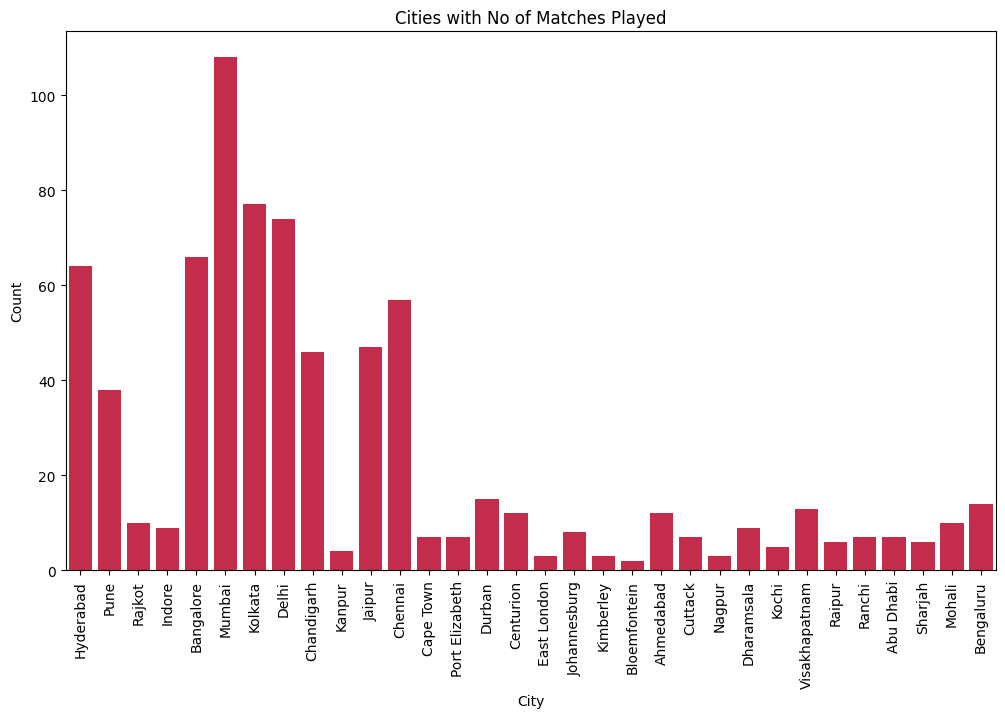

In [14]:
plt.figure(figsize = (12, 7))
sns.countplot(x = df['city'], color = 'crimson')
plt.xticks(rotation = 90)
plt.title("Cities with No of Matches Played")
plt.xlabel("City")
plt.ylabel("Count")
plt.show()

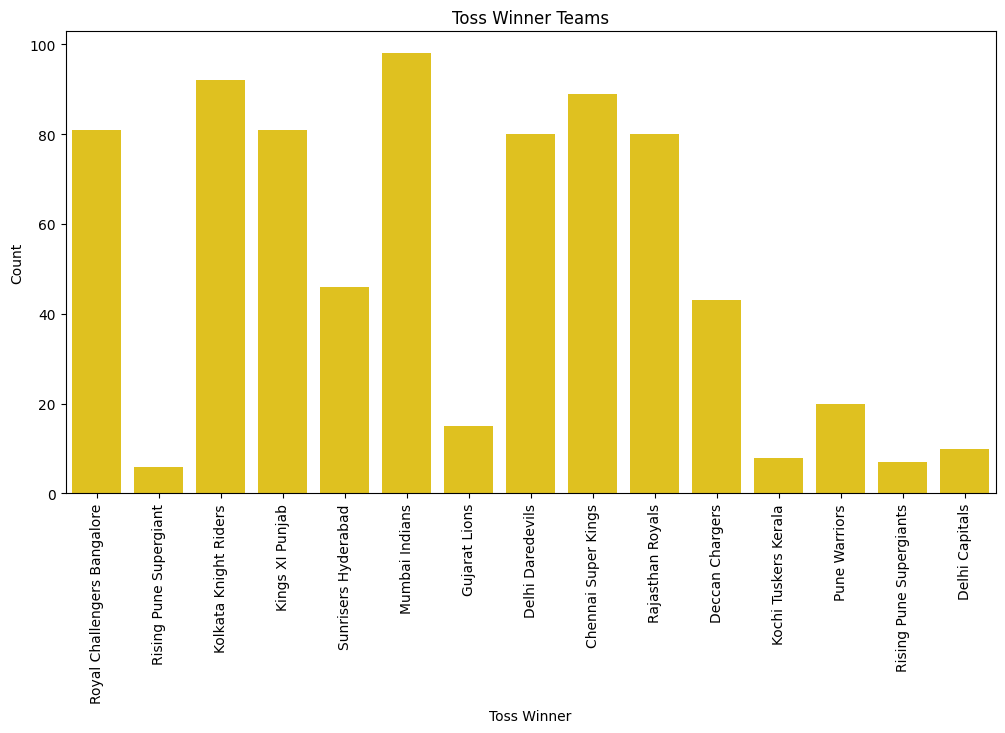

In [15]:
plt.figure(figsize = (12, 6))
sns.countplot(x = df['toss_winner'], color = 'Gold')
plt.xticks(rotation = 90)
plt.title("Toss Winner Teams")
plt.xlabel("Toss Winner")
plt.ylabel("Count")
plt.show()

In [16]:
td_count = df['toss_decision'].value_counts()

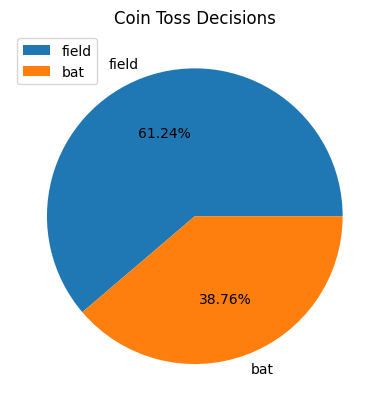

In [17]:
plt.pie(td_count.values, labels = td_count.index, autopct = '%.2f%%')
plt.title("Coin Toss Decisions")
plt.legend(loc = 'upper left')
plt.show()

In [18]:
mr_count = df["result"].value_counts()

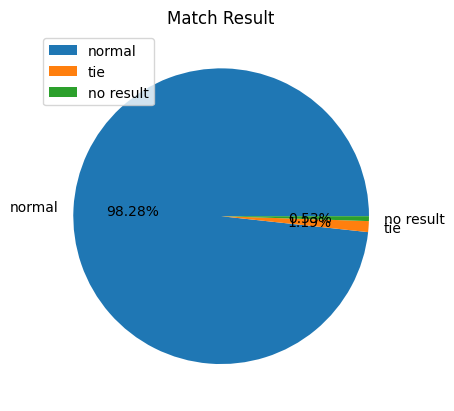

In [19]:
plt.pie(mr_count.values, labels = mr_count.index, autopct =  '%.2f%%')
plt.title("Match Result")
plt.legend(loc = 'upper left')
plt.show()

In [20]:
'''values = mr_count
labels = ['Normal', 'Tie', 'No Result']

fig1 = go.Figure(data = [go.Pie(labels = labels, values = values, hole = 0.3, pull = [0, 1, 0])])
fig1.update_layout(height = 500, width = 500)
fig1.show()'''

"values = mr_count\nlabels = ['Normal', 'Tie', 'No Result']\n\nfig1 = go.Figure(data = [go.Pie(labels = labels, values = values, hole = 0.3, pull = [0, 1, 0])])\nfig1.update_layout(height = 500, width = 500)\nfig1.show()"

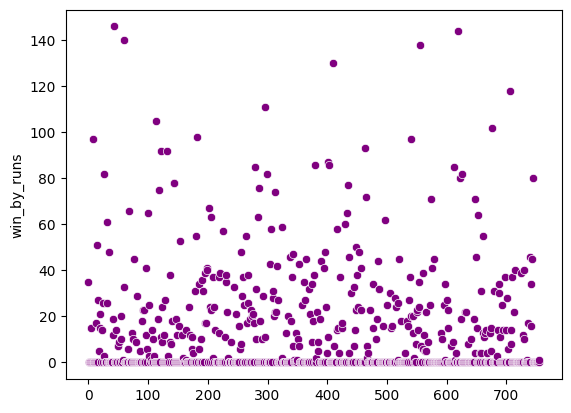

In [21]:
sns.scatterplot(df['win_by_runs'], color = 'purple')
plt.title
plt.show()

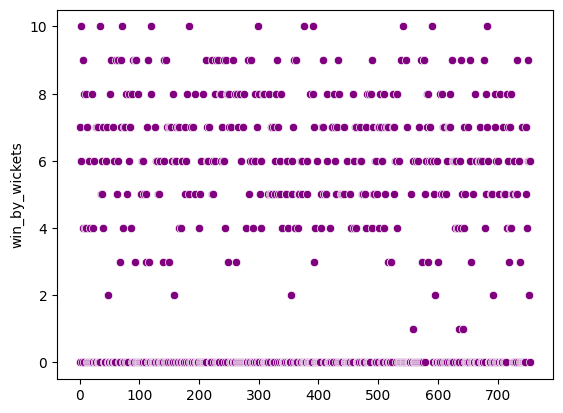

In [22]:
sns.scatterplot(df['win_by_wickets'], color = 'purple')
plt.title
plt.show()

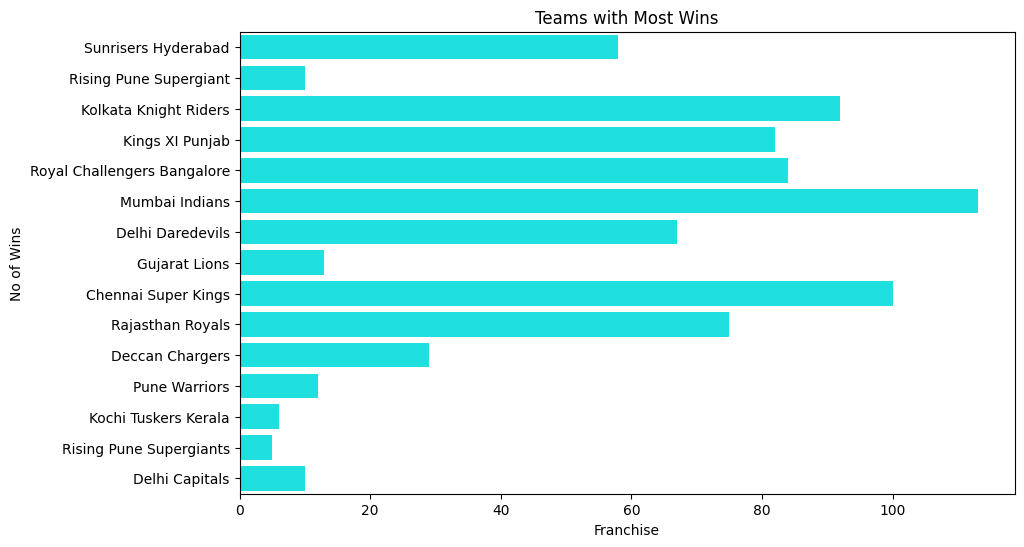

In [23]:
plt.figure(figsize = (10, 6))
sns.countplot(df['winner'], color = 'cyan')
plt.title("Teams with Most Wins")
plt.xlabel("Franchise")
plt.ylabel("No of Wins")
plt.show()

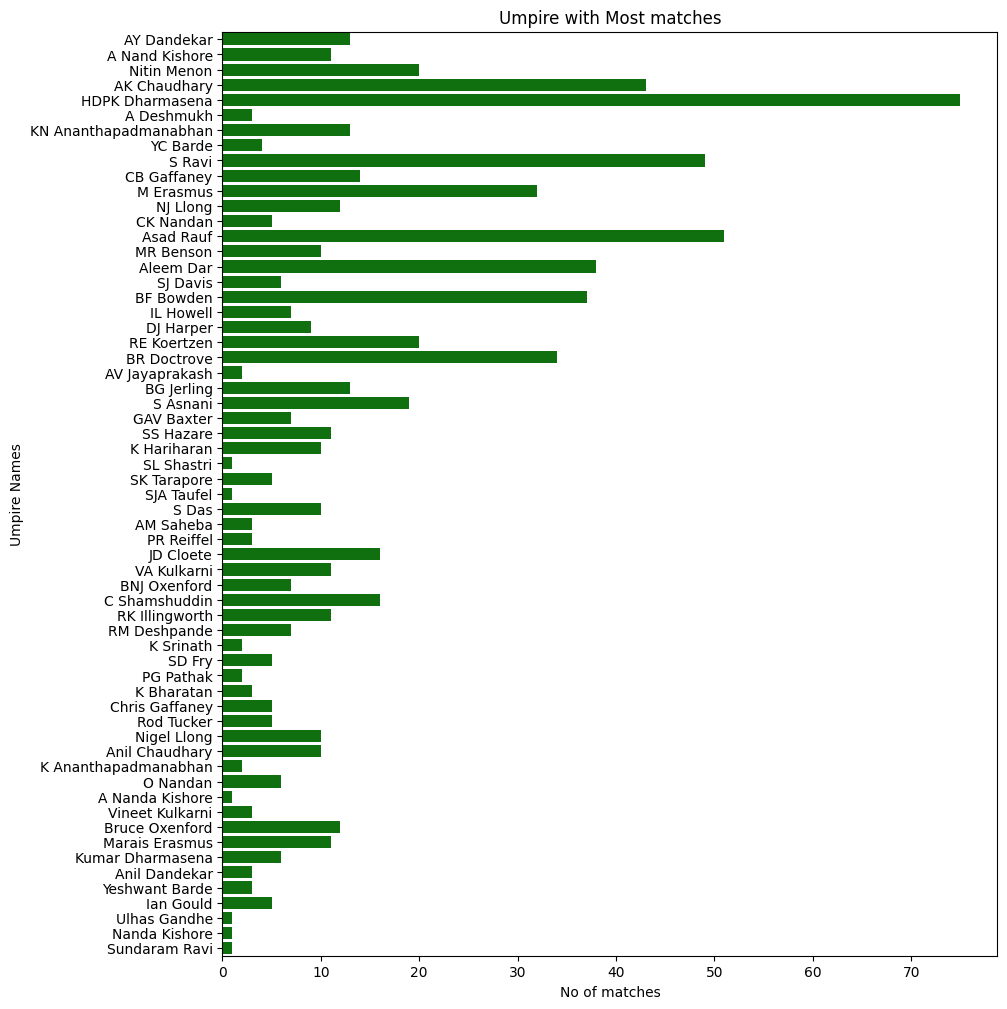

In [24]:
plt.figure(figsize = (10, 12))
sns.countplot(y= df['umpire1'], color = 'green')
plt.title("Umpire with Most matches")
plt.xlabel("No of matches")
plt.ylabel("Umpire Names")
plt.show()

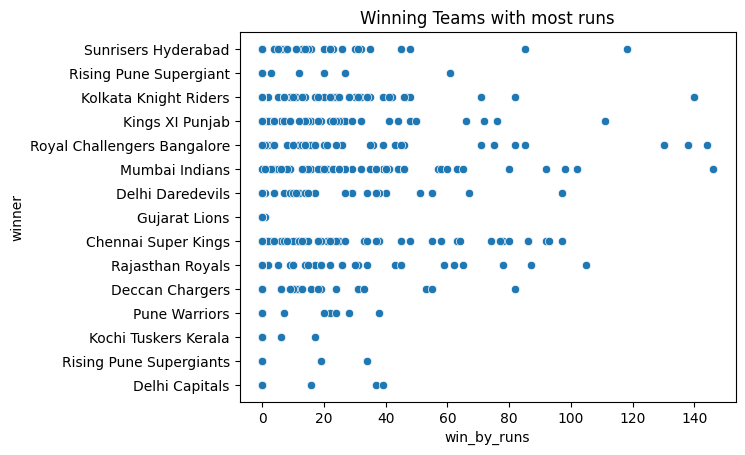

In [25]:
sns.scatterplot(df, x = 'win_by_runs', y = 'winner')
plt.title('Winning Teams with most runs')
plt.show()

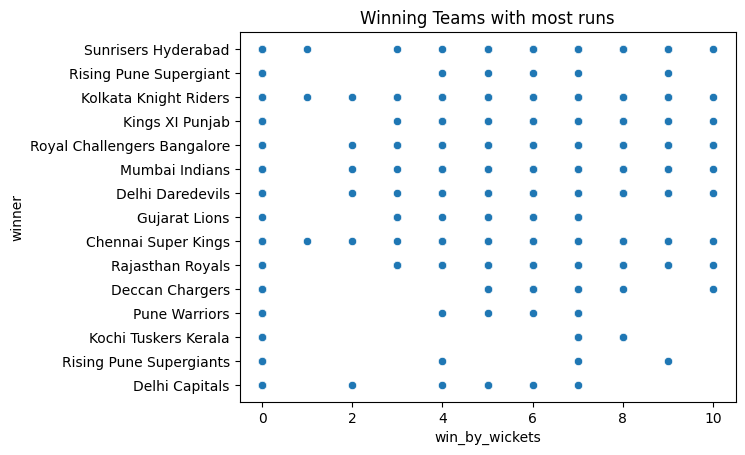

In [26]:
sns.scatterplot(df, x = 'win_by_wickets', y = 'winner')
plt.title('Winning Teams with most runs')
plt.show()

# Data Preprocessing

In [27]:
category_cols_LE = df[['city','team1','team2','toss_winner', 'toss_decision', 'result',
                       'winner','dl_applied', 'player_of_match', 'venue', 'umpire1', 'umpire2']]

In [28]:
label_encoder = LabelEncoder()
for col in category_cols_LE:
    df[col] = label_encoder.fit_transform(df[col])

In [29]:
'''label_encoder = LabelEncoder()
df['city'] = label_encoder.fit_transform(df['city'])
df['team1'] = label_encoder.fit_transform(df['team1'])
df['team2'] = label_encoder.fit_transform(df['team2'])
df['toss_winner'] = label_encoder.fit_transform(df['toss_winner'])
df['toss_decision'] = label_encoder.fit_transform(df['toss_decision'])
df['result'] = label_encoder.fit_transform(df['result'])
df['dl_applied'] = label_encoder.fit_transform(df['dl_applied'])
df['player_of_match'] = label_encoder.fit_transform(df['player_of_match'])
df['venue'] = label_encoder.fit_transform(df['venue'])
df['umpire1'] = label_encoder.fit_transform(df['umpire1'])
df['umpire2'] = label_encoder.fit_transform(df['umpire2'])
df['winner'] = label_encoder.fit_transform(df['winner'])'''

"label_encoder = LabelEncoder()\ndf['city'] = label_encoder.fit_transform(df['city'])\ndf['team1'] = label_encoder.fit_transform(df['team1'])\ndf['team2'] = label_encoder.fit_transform(df['team2'])\ndf['toss_winner'] = label_encoder.fit_transform(df['toss_winner'])\ndf['toss_decision'] = label_encoder.fit_transform(df['toss_decision'])\ndf['result'] = label_encoder.fit_transform(df['result'])\ndf['dl_applied'] = label_encoder.fit_transform(df['dl_applied'])\ndf['player_of_match'] = label_encoder.fit_transform(df['player_of_match'])\ndf['venue'] = label_encoder.fit_transform(df['venue'])\ndf['umpire1'] = label_encoder.fit_transform(df['umpire1'])\ndf['umpire2'] = label_encoder.fit_transform(df['umpire2'])\ndf['winner'] = label_encoder.fit_transform(df['winner'])"

In [30]:
x = df[['city','team1','team2','toss_winner', 'toss_decision', 'result', 'dl_applied', 'player_of_match', 'venue', 'umpire1', 'umpire2']]

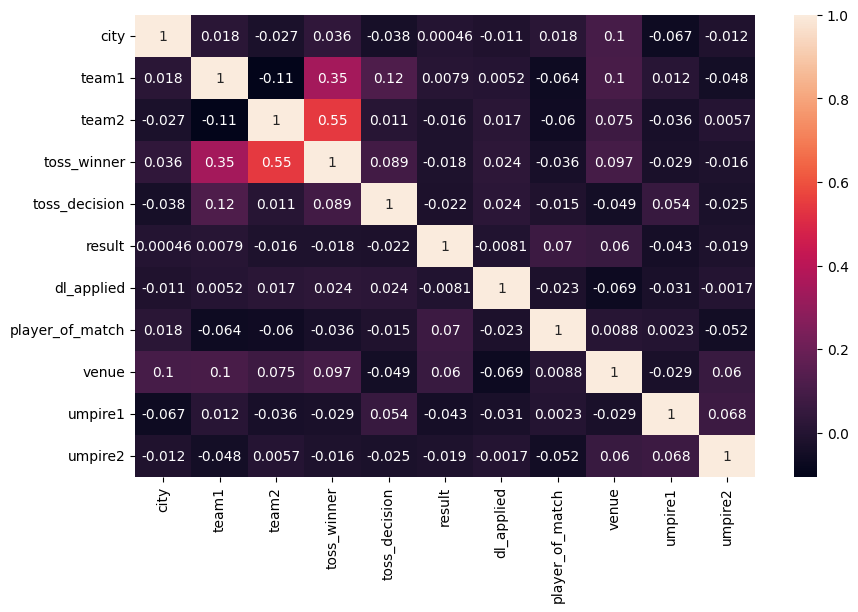

In [31]:
fig = plt.figure(figsize = (10,6))
sns.heatmap(x.corr(), annot = True)
plt.show()

In [32]:
X = df[['team1','team2','toss_winner', 'toss_decision', 'venue']]
y = df['winner']

In [33]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [34]:
# strat_kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# Model Training

## Logistic Regression

In [35]:
model_LR = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')

In [36]:
# #cross_val = cross_val_score(model_LR, X, y, cv = strat_kfold, scoring = 'accuracy')

In [37]:
#print("Cross validation Scores :", cross_val)
#print("Mean Cross Validation Score :", np.mean(cross_val))

In [38]:
model_LR.fit(x_train, y_train)

C:\Users\CheraN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\CheraN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [39]:
y_predict_lr = model_LR.predict(x_test)

In [40]:
acc_score_lr = accuracy_score(y_test, y_predict_lr)
print("Accuracy Score : ", acc_score_lr)

Accuracy Score :  0.2328042328042328


## SVM

In [41]:
model_svm = SVC(kernel = 'linear', random_state = 42)

In [42]:
model_svm.fit(x_train, y_train)

SVC(kernel='linear', random_state=42)

In [43]:
y_predict_svc = model_svm.predict(x_test)

In [44]:
acc_score_svc = accuracy_score(y_test, y_predict_svc)
print("Accuracy Score :", acc_score_svc)

Accuracy Score : 0.2751322751322751


## KNN

In [45]:
k = 3
model_knn = KNeighborsClassifier(n_neighbors = k, metric = 'euclidean')

In [46]:
model_knn.fit(x_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [47]:
y_predict_knn = model_knn.predict(x_test)

In [48]:
acc_score_knn = accuracy_score(y_test, y_predict_knn)
print("Accuracy score : ", acc_score_knn)

Accuracy score :  0.41798941798941797


## Decision Tree

In [49]:
model_DT = DecisionTreeClassifier(max_depth = 5, criterion = 'entropy', random_state = 42)

In [50]:
model_DT.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

In [51]:
y_predict_dt = model_DT.predict(x_test)

In [52]:
acc_score_dt = accuracy_score(y_test, y_predict_dt)
print("Accuracy Score : ", acc_score_dt)

Accuracy Score :  0.4444444444444444


## Random Forest

In [53]:
model_RF = RandomForestClassifier(random_state = 42)

In [54]:
model_RF.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [55]:
y_predict_rf = model_RF.predict(x_test)

In [56]:
acc_score_rf = accuracy_score(y_test, y_predict_rf)
print("Accuracy Score : ", acc_score_rf)

Accuracy Score :  0.5238095238095238


## XGBoost

In [57]:
model_xgb = xgb.XGBClassifier(use_label_encoder = False, eval_metric = 'mlogloss')

In [58]:
model_xgb.fit(x_train, y_train)

C:\Users\CheraN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:158: UserWarning: [10:25:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [59]:
y_predict_xgb = model_xgb.predict(x_test)

In [60]:
acc_score_xgb = accuracy_score(y_test, y_predict_xgb)
print("Accuracy Score : ", acc_score_xgb)

Accuracy Score :  0.5238095238095238


# Model Evaluation

In [61]:
print("Accuracy Score for Logistic Regression :", acc_score_lr)
print("Accuracy Score for SVC :", acc_score_svc)
print("Accuracy Score for KNN :", acc_score_knn)
print("Accuracy Score for  Decision Tree:", acc_score_dt)
print("Accuracy Score for Random Forest :", acc_score_rf)
print("Accuracy Score for XGBoost :", acc_score_xgb)

Accuracy Score for Logistic Regression : 0.2328042328042328
Accuracy Score for SVC : 0.2751322751322751
Accuracy Score for KNN : 0.41798941798941797
Accuracy Score for  Decision Tree: 0.4444444444444444
Accuracy Score for Random Forest : 0.5238095238095238
Accuracy Score for XGBoost : 0.5238095238095238


In [62]:
class_report_lr = classification_report(y_test, y_predict_lr)
class_report_svc = classification_report(y_test, y_predict_svc)
class_report_knn = classification_report(y_test, y_predict_knn)
class_report_dt = classification_report(y_test, y_predict_dt)
class_report_rf = classification_report(y_test, y_predict_rf)
class_report_xgb = classification_report(y_test, y_predict_xgb)

C:\Users\CheraN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\CheraN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\CheraN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classific

In [63]:
print(class_report_lr)

              precision    recall  f1-score   support

           0       0.45      0.58      0.51        33
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         1
           3       0.12      0.07      0.09        14
           4       0.00      0.00      0.00         6
           5       0.14      0.17      0.15        18
           6       0.00      0.00      0.00         1
           7       0.33      0.26      0.29        31
           8       0.11      0.26      0.16        23
           9       0.00      0.00      0.00         4
          10       0.20      0.17      0.18        18
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         3
          13       0.12      0.14      0.13        14
          14       0.33      0.17      0.22        12

    accuracy                           0.23       189
   macro avg       0.12      0.12      0.12       189
weighted avg       0.22   

In [64]:
print(class_report_svc)

              precision    recall  f1-score   support

           0       0.48      0.70      0.57        33
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         1
           3       0.15      0.14      0.15        14
           4       0.00      0.00      0.00         6
           5       0.12      0.11      0.12        18
           6       0.00      0.00      0.00         1
           7       0.38      0.29      0.33        31
           8       0.20      0.43      0.27        23
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00        18
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         3
          13       0.18      0.29      0.22        14
          14       0.22      0.17      0.19        12

    accuracy                           0.28       189
   macro avg       0.12      0.14      0.12       189
weighted avg       0.22   

In [65]:
print(class_report_knn)

              precision    recall  f1-score   support

           0       0.56      0.67      0.61        33
           1       0.10      0.11      0.11         9
           2       0.00      0.00      0.00         1
           3       0.22      0.36      0.27        14
           4       0.00      0.00      0.00         6
           5       0.44      0.39      0.41        18
           6       0.00      0.00      0.00         1
           7       0.64      0.45      0.53        31
           8       0.37      0.57      0.45        23
           9       0.00      0.00      0.00         4
          10       0.60      0.50      0.55        18
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         3
          13       0.27      0.29      0.28        14
          14       0.40      0.33      0.36        12

    accuracy                           0.42       189
   macro avg       0.24      0.24      0.24       189
weighted avg       0.41   

In [66]:
print(class_report_dt)

              precision    recall  f1-score   support

           0       0.59      0.67      0.63        33
           1       0.14      0.11      0.12         9
           2       1.00      1.00      1.00         1
           3       0.20      0.21      0.21        14
           4       0.00      0.00      0.00         6
           5       0.38      0.28      0.32        18
           6       0.00      0.00      0.00         1
           7       0.62      0.84      0.71        31
           8       0.32      0.57      0.41        23
           9       0.00      0.00      0.00         4
          10       0.62      0.28      0.38        18
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         3
          13       0.32      0.50      0.39        14
          14       0.33      0.08      0.13        12

    accuracy                           0.44       189
   macro avg       0.30      0.30      0.29       189
weighted avg       0.41   

In [67]:
print(class_report_rf)

              precision    recall  f1-score   support

           0       0.71      0.52      0.60        33
           1       0.60      0.33      0.43         9
           2       0.00      0.00      0.00         1
           3       0.39      0.50      0.44        14
           4       1.00      0.67      0.80         6
           5       0.33      0.44      0.38        18
           6       0.00      0.00      0.00         1
           7       0.55      0.52      0.53        31
           8       0.52      0.74      0.61        23
           9       0.00      0.00      0.00         4
          10       0.69      0.61      0.65        18
          11       1.00      1.00      1.00         2
          12       0.00      0.00      0.00         3
          13       0.43      0.71      0.54        14
          14       0.50      0.33      0.40        12

    accuracy                           0.52       189
   macro avg       0.45      0.42      0.42       189
weighted avg       0.54   

In [68]:
print(class_report_xgb)

              precision    recall  f1-score   support

           0       0.68      0.52      0.59        33
           1       0.38      0.33      0.35         9
           2       0.00      0.00      0.00         1
           3       0.30      0.43      0.35        14
           4       1.00      0.67      0.80         6
           5       0.39      0.50      0.44        18
           6       0.00      0.00      0.00         1
           7       0.57      0.52      0.54        31
           8       0.57      0.74      0.64        23
           9       0.00      0.00      0.00         4
          10       0.64      0.78      0.70        18
          11       1.00      0.50      0.67         2
          12       0.00      0.00      0.00         3
          13       0.40      0.57      0.47        14
          14       0.67      0.33      0.44        12

    accuracy                           0.52       189
   macro avg       0.44      0.39      0.40       189
weighted avg       0.53   

# Hyperparameter Tuning

In [69]:
RF = RandomForestClassifier()

## Random Search

In [70]:
param_dist = {
    'n_estimators': np.arange(50, 500, 50),  
    'max_depth': [None, 10, 20, 30, 50],  
    'min_samples_split': np.arange(2, 10, 2), 
    'min_samples_leaf': np.arange(1, 5),  
    'max_features': ['sqrt', 'log2'] 
}

In [71]:
random_search_rf = RandomizedSearchCV(RF, param_distributions = param_dist, n_iter = 20, cv = 5, 
                                   scoring = 'accuracy', n_jobs = -1, random_state = 42)

In [72]:
random_search_rf.fit(x_train, y_train)

C:\Users\CheraN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 50],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': array([1, 2, 3, 4]),
                                        'min_samples_split': array([2, 4, 6, 8]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450])},
                   random_state=42, scoring='accuracy')

In [73]:
print("Best Parameters from Random Search:", random_search_rf.best_params_)

Best Parameters from Random Search: {'n_estimators': np.int64(450), 'min_samples_split': np.int64(2), 'min_samples_leaf': np.int64(4), 'max_features': 'log2', 'max_depth': 10}


In [74]:
ypredict_rfrs = random_search_rf.predict(x_test)

In [75]:
acc_score_rfrs = accuracy_score(y_test, ypredict_rfrs)
print("Accuracy score Random search CV : ",acc_score_rfrs)

Accuracy score Random search CV :  0.5343915343915344


## Grid Search

In [76]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [77]:
grid_search_rf = GridSearchCV(RF, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(x_train, y_train)

C:\Users\CheraN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [78]:
print("Best Parameters from Grid Search:", grid_search_rf.best_params_)

Best Parameters from Grid Search: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [79]:
ypredict_rfgs = grid_search_rf.predict(x_test)

In [80]:
acc_score_rfgs = accuracy_score(y_test, ypredict_rfgs)
print("Accuracy score Grid search CV :", acc_score_rfgs)

Accuracy score Grid search CV : 0.544973544973545


# Model Comparison

In [81]:
print("\n--- Model Performance Comparison ---")
print(f"Baseline Model Accuracy: {acc_score_rf:.4f}")
print(f"Random Search Tuned Model Accuracy: {acc_score_rfrs:.4f}")
print(f"Grid Search Tuned Model Accuracy: {acc_score_rfgs:.4f}")


--- Model Performance Comparison ---
Baseline Model Accuracy: 0.5238
Random Search Tuned Model Accuracy: 0.5344
Grid Search Tuned Model Accuracy: 0.5450


In [82]:
best_model = None
best_model_name = ""

if acc_score_rfgs >= acc_score_rfrs and acc_score_rfgs >= acc_score_rf:
    best_model = grid_search_rf
    best_model_name = "Grid Search Tuned Model"
elif acc_score_rfrs >= acc_score_rfgs and acc_score_rfrs >= acc_score_rf:
    best_model = random_search_rf
    best_model_name = "Random Search Tuned Model"
else:
    best_model = model_RF
    best_model_name = "Baseline Model"

print(f"\nBest Performing Model: {best_model_name}")


Best Performing Model: Grid Search Tuned Model


## Saving the model

In [83]:
with open("best_random_forest_model.pkl", "wb") as file:
    pickle.dump(best_model, file)

print("Best Model saved as 'best_random_forest_model.pkl'")

Best Model saved as 'best_random_forest_model.pkl'
